# Hopfield Network With Hashing - Hopfield

This is a memory mechanism in a form of a Hopfield network. The stored items are called memory patterns. They are retrieved by a process of the input that is presented to the network dynamics which at some time step reaches a fixed stable point. This means that the input item has been recognized (i.e. there is a memory pattern identical or very similar to it).

Even noisy sounds or those corrupted to some extent can be accessed. In other words, if the input is $x_1 + \delta$ and the stored item is $x_1$, the network will still reach the fixed point of $x_1$ if $\delta$ is small enough.

Additionally, for storage purposes, sounds are transformed each into a hash - with this we reduce their dimensionality. This means we increase the storage capacity. 

### Load dependencies

In [183]:
# First, we load the neccessary dependencies.

import numpy as np
import math
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import sys
import glob
import random
import matplotlib.pyplot as plt

In [184]:
# Folder with some wav files to test this script.

folder_train = "./wavs/"

### Extract Features

First, we will transform our .wav files into features, in this case MFCCs.

In [185]:
def make_mfcc(folder):
    """
    Go through the folder and find all (and only) files ending with .wav
    Here, we transform each .wav file into MFCCs and then flatten them into one vector.
    We do this because we want one hash per .wav file.
    
    Parameters
    ----------
    folder : path to folder with wav sounds
    
    Returns
    -------
    a list of flattened MFCC vectors
    """
    
    vectors = []
    for file in glob.glob(folder + "*.wav", recursive=True):
        (rate,sig) = wav.read(file)
        mfcc_feat = mfcc(sig,rate)
        vect = mfcc_feat.flatten()
        vectors.append(vect)
    return vectors

### Hashing of features

Now we will use these features and transform them into hash vectors, which we will use to store in our memory. We do this to facilitate memory storage: hashes are vectors with reduced dimensionality, with values mostly equal to 0 and a few of them equal to 1.

In [186]:
def hash_dim(d,k,m,seed):  
    
    """
    Define hash parameters.
    The hash will be a matrix of the dimension = k*m
    We choose a random number k of units of the vector.
    
    Parameters
    ----------
    d : num
        Length of a random vector being stored
    k : num
        Number of units we randomly choose of the vector
    m : num
        Number of times we will  do the hashing for some vector
    seed : num
        We always want the same units randomly chosen
        
    Returns
    -------
    a numpy array 
        p of dimensions [k,m] represents randomly chosen dimensions
    
    """   
    
    assert k <= d
    p = np.zeros((m,k,))
    np.random.seed(seed)
    for i in range(m):
        p[i] = np.random.permutation(d)[:k]
    return p

    
def get_hash(vector, k, m, p): 
    """
    Transform a vector of speech into a hash
    The hash will be a matrix of the dimension = k*m
    
    Once we have chosen k random dimensions, we look for the highest 
    value and turn it into 1. Everything else is 0.
    We thus get sparse matrices.
    We do this m times. Final output is h=k*m.
    
    Parameters
    ----------
    vector : np.array
        Features (i.e. MFCC) of some sound with dim = 1*n
    k : num
        Number of units we randomly choose of the vector
    m : num
        Number of times we will do the hashing for some vector.
    p : numpy array
        p of dimensions [k,m] represents randomly chosen dimensions
        
    Returns
    -------
    a numpy array h of size [1, k*m]
    """
    
    h = np.zeros((m,k,))
    for i in range(m):
        p_line = p[i]
        ix = np.argmax(vector[p_line])
        hi = np.zeros(k)
        hi[ix] = 1
        h[i] = hi
    h = np.hstack(h)
    return h


# TEST

expected_h = np.array([[1,0,0],[0,0,1]]).flatten()
vector = np.array([6,4,5,9,2])
p0 = hash_dim(len(vector),3,2,2).astype(int)
print("This is a test hash: ", get_hash(vector, 3, 2, p0))
assert get_hash(vector, 3, 2, p0).all() == expected_h.all()

This is a test hash:  [1. 0. 0. 0. 0. 1.]


### Memory storage

We must now construct our neuron weight matrix that reopresents the connections between neurons of our memory network.
We will first initialize our matrix representing the synaptic weights and then enable subsequent addition of new memories.

Synaptic weight matrix is a matrix that represents connections between each and every neuron. Every neuron has a state which can be active or inactive. Initialization of synaptic weights will make the connection between two neurons such that it is strengthened if both neurons are active (and the other way round, it will weaken the connection if one of the neurons is inactive).

In [187]:
def initialize_network(N, V=None):
    """
    V=()
    Eq. (2) from [1]
    
    Initialize synaptic weights in form of matrix T (symmetric recurrent weight matrix).
    This is a memory storage.
    
    Parameters
    ----------
    N : num
        number of neurons
    V : list
        list of vectors in a hash form
        
    Returns
    -------
    a numpy array T of shape (N, N)
        Memory storage in form of a matrix (synaptic weights)
        Its dimensions are determined by N=k*m (hash parameters)
    """

    T = np.zeros((N,N))
    if V != None:
        for vect in V:
            #outer_prod = np.outer((2*vect - 1),(2*vect - 1))
            T = add_memory(T, vect)
            #T += outer_prod
        
    return T


def add_memory(T, new_memory):
    """
    Eq. (2) from [1]
    
    Initialize synaptic weights in form of matrix T (symmetric recurrent weight matrix).
    This is a memory storage.
    
    Parameters
    ----------
    T : a numpy array T_sum of shape (N, N)
        Initialized memory storage in form of a matrix (synaptic weights)
    new_memory : numpy array of shape (1,N)
        a vector we wish to store
        
    Returns
    -------
    a numpy array T of shape (N, N)
        Renewed memory storage in form of a matrix (synaptic weights)
        Its dimensions are determined by N=k*m (hash parameters)
    """
    
    outer_prod = np.outer((2*new_memory - 1),(2*new_memory - 1))
    T += outer_prod
        
    return T

# TEST
# calcul a la main d'une matrice + added memory

### Memory retrieval

To see when we have reached a stable fixed point, we use the energy function E, which is a monotonically decreasing function - state changes continue until a local E is reached.

In [250]:
def energy(T, V):
    """
    Eq. (7) from [1]
    
    Energy of the system is a monotonically decreasing function.
    
    Parameters
    ----------
    T : a numpy array of shape (N, N)
        Memory in form of a matrix (synaptic weights)
    V : numpy array
        a list of states of activation
        
    Returns
    -------
    num
        Energy of the system
    """
    E = 0
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            E -= 1/2 * (T[i,j] * V[i] * V[j])
    return E
    
# test a la main + matrix simple + vector simple

In [267]:
def update_neuron(T, V_j, i):
    """
    FIXME
    We calculate T_ij * V_j, where T_ij is a row in our synaptic weight matrix
    and V_j is a j-th neuron state 
    
    Parameters
    ----------
    T : a numpy array T_sum of shape (N, N)
        Initialized memory storage in form of a matrix (synaptic weights)
    V_j : num
        a scalar representing j-th neuron's state
        
    Returns
    -------
    list
        We return the updated i-th row of matrix T
    """
    T_i = T[i] * V_j
    return T_i

def check_convergence(TV_sum, U):
    """
    Check whether the sum of T_ij * V_j is bigger or smaller than the threshold

    Parameters
    ----------
    TV_sum : num
        Sum over T_ij * V_j
    U : num
        a scalar representing a threshold of neuron's state of activity
        
    Returns
    -------
    num
        We return either 0 or 1, depending on TV_sum being smaller
        or larger than the threshold U
    """
    if TV_sum > U:
        return 1
    if TV_sum <= U:
        return 0
    
def retrieve_memory(T, V0, U=0):
    """
    Eq. (1) from [1]
    
    To retrieve a memory, we want to find the stable/fixed point of the 
    dynamic network represented by matrix T (synaptic weights in which
    the memory is stored) when starting from vector V.

    Parameters
    ----------
    T : a numpy array T of shape (N, N)
        Memory in form of a matrix (synaptic weights)
    V : a numpy array of shape (1, N)
        a vector with which we initialize the network activity (check if it is stored in T)
    U : num
        a scalar representing the threshold of neuron's state of activity
        
    Returns
    -------
    a numpy array of shape (1, N)
        We return the new / denoised V
    """
    
    V = V0
#     E_list = []
    
#     update T, call function - do a sum , T_ij*V_j
    
    while not check_convergence():
        np.random.seed(SEED)
        i = random.randint(0,len(V)-1)
        TVi
        V_i = update_neuron(T,V_i)
    
    
    for j in range(T.shape[0]):
        rand_j = random.randint(0,len(V)-1)
        # we sum over i != j
        if i != rand_j:
            # choose random j from the vector V0
            V_j = V[rand_j]
            # update T_i with V_j
            T_i = update_neuron(T, V_j, i)
            # sum values of T_i to evaluate it
            TV_sum = sum(T_i)
            # check value of V_i by comparing TV_sum and U
            V_i = check_convergence(TV_sum, U)
            # calculate energy
            E = energy(T, V)
            # store current energy in a list
            E_list.append(E)
            print(E)
        
        # check if the current energy value is the same as the previous value
        # and if current V_i is the same as it was before updating
        if E == E_list[-1] and V0[rand_j] == V_i:
            return V
        else:
            V0[rand_j] = V_i

retrieve_memory(T, V[1])


K = V[1]
K[0] += 1
K[4] += 1
print(retrieve_memory(T, K))
print(K)

# full_trace=True, stock all states by which you pass, have E_list, return V list of all Vs
# USE this result to calculate energy and do plot
#     S_i
#     V initalise avec [-1], change i of last thing on the list
#     update neuron, add to the end of lsit
    
#     V = liste qio contient V0

-10.0
-24.0
[3. 1. 0. 0. 3. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
[3. 1. 0. 0. 3. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]


We can now inspect our memory network and test it:

In [188]:
# Test with random dimensions k, m, N, which determine the size of T and of hash vectors:

k = 5
m = 3
N = 15
V =[]

p = hash_dim(325,k,m,27).astype(int)
mfccs_vectors = make_mfcc(folder_train)
for vect in mfccs_vectors:
    v = get_hash(vect, k, m, p)
    V.append(v)

T = initialize_network(N, V[0:4])

### Testing 

In [189]:
# We can inspect how one of our hashed vectors looks like:

print(V[0])

[array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([0., 0., 0., 1., 0., 0., 0.

We can also see here how our matrix T (symmetric recurrent weight matrix) looks like:

In [268]:
# We can inspect how our transition matrix looks like:

print(T)

[[ 4.  2.  4.  0.  2.  4.  4.  4. -2.  2.  4.  2. -2.  4.  4.]
 [ 2.  4.  2. -2.  0.  2.  2.  2.  0.  0.  2.  0.  0.  2.  2.]
 [ 4.  2.  4.  0.  2.  4.  4.  4. -2.  2.  4.  2. -2.  4.  4.]
 [ 0. -2.  0.  4. -2.  0.  0.  0. -2.  2.  0.  2. -2.  0.  0.]
 [ 2.  0.  2. -2.  4.  2.  2.  2.  0.  0.  2.  0.  0.  2.  2.]
 [ 4.  2.  4.  0.  2.  4.  4.  4. -2.  2.  4.  2. -2.  4.  4.]
 [ 4.  2.  4.  0.  2.  4.  4.  4. -2.  2.  4.  2. -2.  4.  4.]
 [ 4.  2.  4.  0.  2.  4.  4.  4. -2.  2.  4.  2. -2.  4.  4.]
 [-2.  0. -2. -2.  0. -2. -2. -2.  4. -4. -2. -4.  4. -2. -2.]
 [ 2.  0.  2.  2.  0.  2.  2.  2. -4.  4.  2.  4. -4.  2.  2.]
 [ 4.  2.  4.  0.  2.  4.  4.  4. -2.  2.  4.  2. -2.  4.  4.]
 [ 2.  0.  2.  2.  0.  2.  2.  2. -4.  4.  2.  4. -4.  2.  2.]
 [-2.  0. -2. -2.  0. -2. -2. -2.  4. -4. -2. -4.  4. -2. -2.]
 [ 4.  2.  4.  0.  2.  4.  4.  4. -2.  2.  4.  2. -2.  4.  4.]
 [ 4.  2.  4.  0.  2.  4.  4.  4. -2.  2.  4.  2. -2.  4.  4.]]


Now we will test our memory and see what the energy function of a vector already stored in memory is and compare it to a vector not stored in memory:

In [212]:
# Let us now see how the energy function works when we tested it:
# E_test is a vector impossible to obtain from our hashing method - 
# it should show no fixed point
# E_V0 uses as test the first hashed vector (identical to the stored data)

V_unstored = [3, 1, 4, 1, 0, 0, 0, 0, 7, 0, 9, 0, 7, 0, 4]
E = energy(T, V)

# We can see the energy as it gradually stabilizes
print(energy(T, V))

-14.0


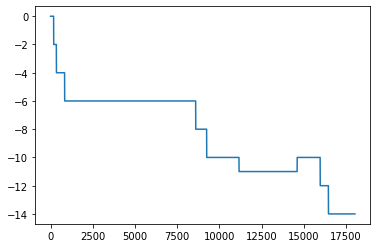

In [205]:
# Let's plot the energy data

plt.plot(E)
plt.show()

In [29]:
# TEST
# robustness
# precision/recall
# size of input that can be stocked
# nature of stimuli
# nature of hash
# put silence at the end so all have the same length
# link to ref - this equation num. from this paper

### References

[1] Hopfield, J. J. (1982). Neural networks and physical systems with emergent collective computational abilities. Proceedings of the national academy of sciences, 79(8), 2554-2558. 
[https://doi.org/10.1073/pnas.79.8.2554]

[2] Andoni, A., & Indyk, P. (2006, October). Near-optimal hashing algorithms for approximate nearest neighbor in high dimensions. In 2006 47th annual IEEE symposium on foundations of computer science (FOCS'06) (pp. 459-468). IEEE.
[https://10.1109/FOCS.2006.49]